In [33]:
import sys
sys.path.append("crypto-volatility-lab")

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from crypto_volatility_lab.modeling import LSTMGRUPipeline, TCNNPipeline, GRUPipeline, LSTMPipeline
from crypto_volatility_lab.data_construction import CryptoScraper, FeaturesCreator, TimeSeriesCreator
from crypto_volatility_lab.portfolio_optimization.portfolioConstructor import PortfolioConstructor
import pandas as pd

In [34]:
currency_list = ['BTC-USD', 'ETH-USD', 'LTC-USD']
test_start_date = datetime.strptime('2023-01-01', "%Y-%m-%d")

# Récupération des données

On va scraper les données de Yahoo Finance. L'objet CryptoScraper nous permet de réaliser cela. L'objet prend par défaut le maximum de l'historique jusqu'à la date d'aujourd'hui.

In [35]:
crypto_scraper = CryptoScraper()

In [36]:
ethereum_data = crypto_scraper.get_data_for_currency('ETH-USD')

In [37]:
# Exemple de données
ethereum_data.head()

,Date,Open,High,Low,Close,Adj,Volume
0,2025-01-23,3241.24,3287.35,3186.24,3261.50,3261.50,31202093056
1,2025-01-22,3327.24,3364.75,3223.39,3240.22,3240.22,22171220981
2,2025-01-21,3278.44,3365.78,3202.49,3327.41,3327.41,32804001146
3,2025-01-20,3208.93,3444.28,3147.52,3278.04,3278.04,52383187336
4,2025-01-19,3305.40,3444.21,3127.62,3208.96,3208.96,57242875399


# Création des time series

In [38]:
ts_creator = TimeSeriesCreator(data=ethereum_data, date_column_name='Date', value_column_name='Close')
ethereum_data["Log Returns"] = ts_creator.create_log_return_time_series()
ethereum_data["Volatility"] = ts_creator.create_volatility_time_series()

# Exemple de données
ethereum_data.head()

,Date,Open,High,Low,Close,Adj,Volume,Log Returns,Volatility
2632,2017-11-09,308.64,329.45,307.06,320.88,320.88,893249984,NaN,NaN
2631,2017-11-10,320.67,324.72,294.54,299.25,299.25,885985984,-0.069788,NaN
2630,2017-11-11,298.59,319.45,298.19,314.68,314.68,842300992,0.050277,NaN
2629,2017-11-12,314.69,319.15,298.51,307.91,307.91,1613479936,-0.021749,NaN
2628,2017-11-13,307.02,328.42,307.02,316.72,316.72,1041889984,0.028211,NaN


In [39]:
print(ethereum_data.shape)
ethereum_data.dropna(inplace=True)
print(ethereum_data.shape)

(2633, 9)
(2612, 9)


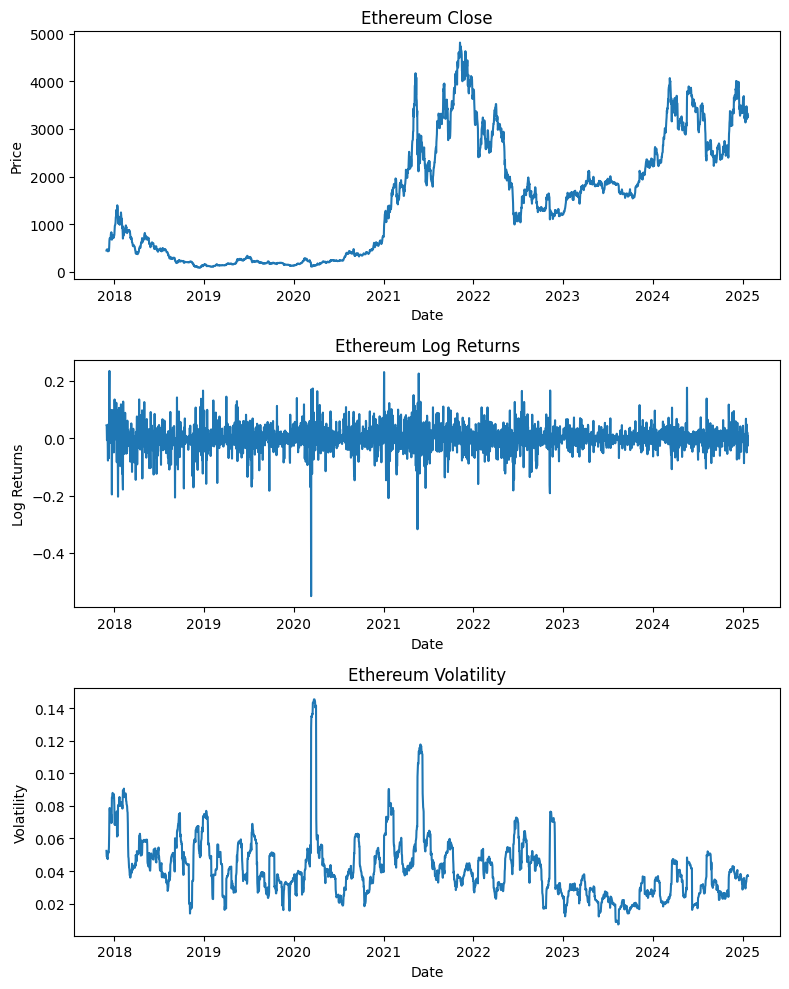

In [40]:
metrics = [
    ("Close", "Price"),
    ("Log Returns", "Log Returns"),
    ("Volatility", "Volatility"),
]

fig, ax = plt.subplots(len(metrics), 1, figsize=(8, 10))

for row, (metric, ylabel) in enumerate(metrics):
    ax[row].plot(ethereum_data["Date"], ethereum_data[metric])
    ax[row].set_title(f"Ethereum {metric}")
    ax[row].set_xlabel("Date")
    ax[row].set_ylabel(ylabel)

plt.tight_layout()
plt.show()


# Feature engineering

In [41]:
features_creator_ethereum = FeaturesCreator(data=ethereum_data)

features_creator_ethereum.create_all_features()

ethereum_data = features_creator_ethereum.transformed_data

features = features_creator_ethereum.features_names

# Exemple de données
ethereum_data.head()

,Date,Open,High,Low,Close,Adj,Volume,Log Returns,Volatility,Weekly Volatility,Monthly Volatility,Log Trading Range,Log Volume Change
2611,2017-11-30,431.21,465.50,401.24,447.11,447.11,1903040000,0.044804,0.052388,0.052388,0.052388,0.148552,NaN
2610,2017-12-01,445.21,472.61,428.31,466.54,466.54,1247879936,0.042539,0.048826,0.050607,0.050607,0.098423,-0.422007
2609,2017-12-02,466.85,476.24,456.65,463.45,463.45,943649984,-0.006645,0.048707,0.049974,0.049974,0.042005,-0.279446
2608,2017-12-03,463.70,482.81,451.85,465.85,465.85,990556992,0.005165,0.047945,0.049466,0.049466,0.066273,0.048512
2607,2017-12-04,466.05,474.78,453.31,470.20,470.20,1005550016,0.009294,0.047955,0.049164,0.049164,0.046275,0.015023


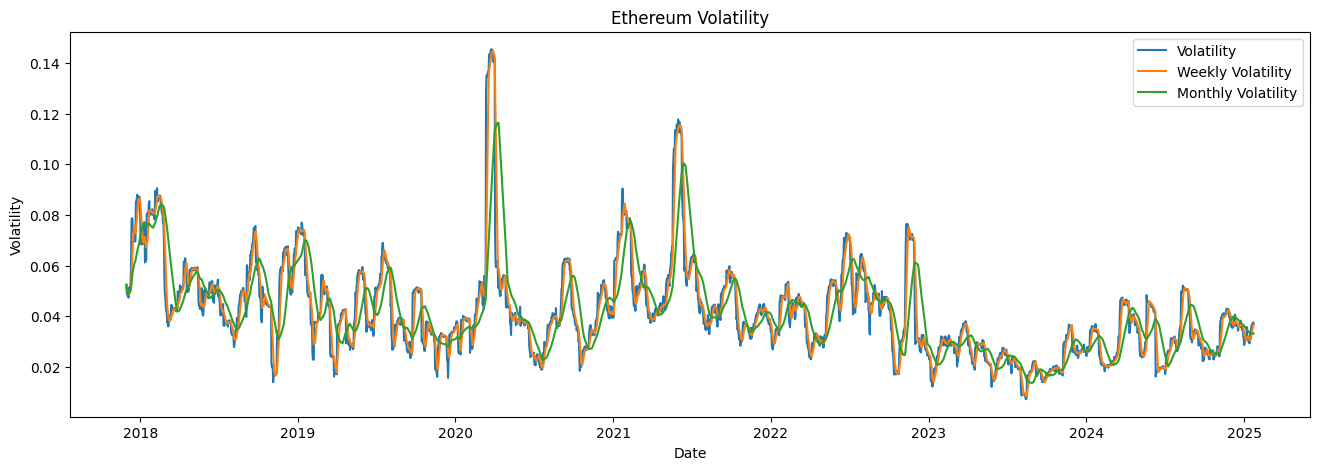

In [42]:
# plot volatility, weekly volatility, monthly volatility on the same plot
plt.figure(figsize=(16, 5))
plt.plot(ethereum_data["Date"], ethereum_data["Volatility"], label="Volatility")
plt.plot(ethereum_data["Date"], ethereum_data["Weekly Volatility"], label="Weekly Volatility")
plt.plot(ethereum_data["Date"], ethereum_data["Monthly Volatility"], label="Monthly Volatility")
plt.title("Ethereum Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

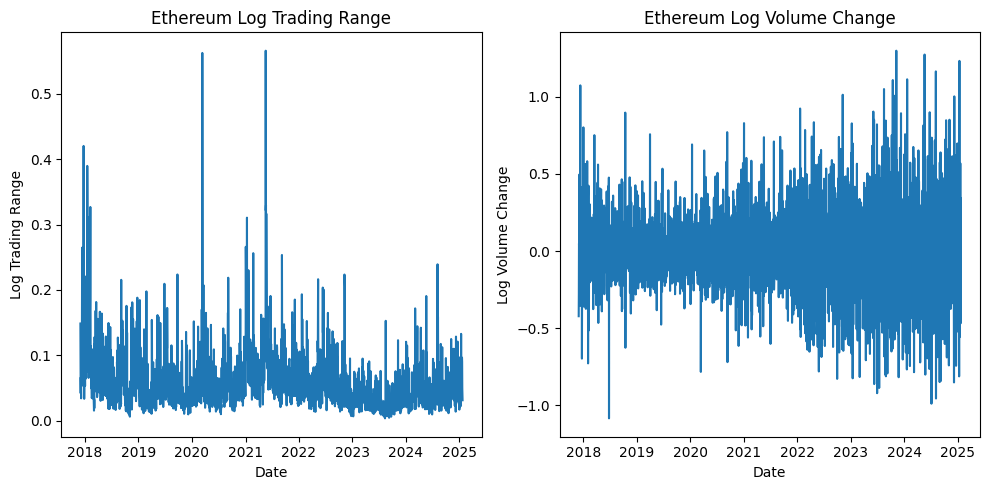

In [43]:
# plot log trading range and log volume change for bitcoin 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(ethereum_data["Date"], ethereum_data["Log Trading Range"])
ax[0].set_title("Ethereum Log Trading Range")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Log Trading Range")
ax[1].plot(ethereum_data["Date"], ethereum_data["Log Volume Change"])
ax[1].set_title("Ethereum Log Volume Change")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Log Volume Change")
plt.tight_layout()
plt.show()

In [44]:
# # plot garch volatility, realized volatility on the same plot for the 3 cryptocurrencies subplots
# fig, ax = plt.subplots(3, 1, figsize=(13, 5))

# ax[0].plot(bitcoin_data["Date"], bitcoin_data["Volatility"], label="Volatility")
# ax[0].plot(bitcoin_data["Date"], bitcoin_data["GARCH Volatility"], label="GARCH Volatility")
# ax[0].set_title("Bitcoin Volatility")
# ax[0].set_xlabel("Date")
# ax[0].set_ylabel("Volatility")
# ax[0].legend()

# ax[1].plot(ethereum_data["Date"], ethereum_data["Volatility"], label="Volatility")
# ax[1].plot(ethereum_data["Date"], ethereum_data["GARCH Volatility"], label="GARCH Volatility")
# ax[1].set_title("Ethereum Volatility")
# ax[1].set_xlabel("Date")
# ax[1].set_ylabel("Volatility")
# ax[1].legend()

# ax[2].plot(litecoin_data["Date"], litecoin_data["Volatility"], label="Volatility")
# ax[2].plot(litecoin_data["Date"], litecoin_data["GARCH Volatility"], label="GARCH Volatility")
# ax[2].set_title("Litecoin Volatility")
# ax[2].set_xlabel("Date")
# ax[2].set_ylabel("Volatility")
# ax[2].legend()

# plt.tight_layout()
# plt.show()

# Train/test split

In [45]:
ethereum_data.dropna(inplace=True)

In [46]:

ethereum_train_data = ethereum_data[ethereum_data['Date'] < test_start_date]
ethereum_test_data = ethereum_data[ethereum_data['Date'] >= test_start_date]

# check proportion of test data
print(f"Ethereum test data proportion: {round(len(ethereum_test_data) / len(ethereum_data)*100, 2)}%")


Ethereum test data proportion: 28.88%


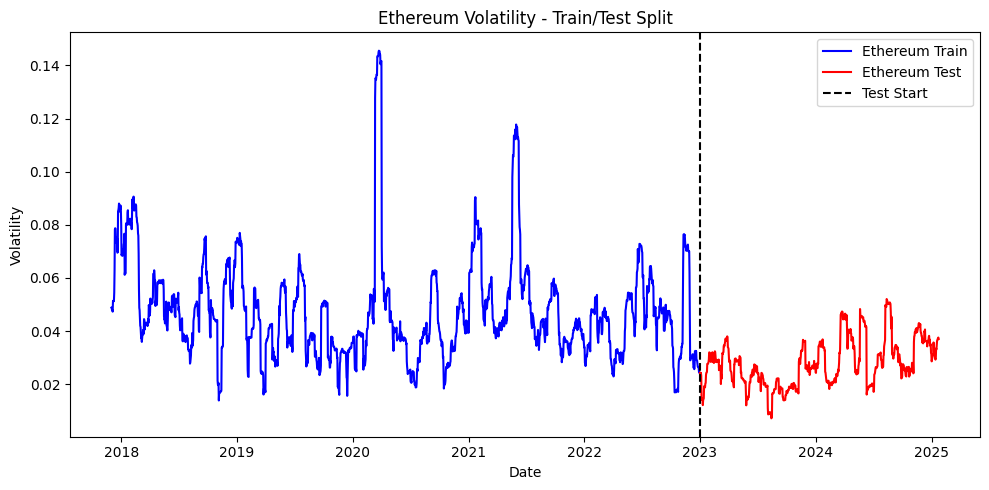

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(ethereum_train_data["Date"], ethereum_train_data["Volatility"], label="Ethereum Train", color="blue")
ax.plot(ethereum_test_data["Date"], ethereum_test_data["Volatility"], label="Ethereum Test", color="red")
ax.axvline(test_start_date, color="black", linestyle="--", label="Test Start")
ax.set_title("Ethereum Volatility - Train/Test Split")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility")
ax.legend()

plt.tight_layout()
plt.show()


# Prédiction de la volatilité

In [48]:
features = features_creator_ethereum.features_names
features

['Volatility',
 'Weekly Volatility',
 'Monthly Volatility',
 'Log Trading Range',
 'Log Volume Change']

In [49]:
# ethereum model
ethereum_pipeline = GRUPipeline(forecast_horizon=5, epochs=5, batch_size=32, validation_split=0.1, dropout_rate=0, normalize=True)
ethereum_model= ethereum_pipeline.fit(ethereum_train_data[features].values, ethereum_train_data["Volatility"].values.astype(np.float64))

Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0206 - val_loss: 0.0041
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0036 - val_loss: 0.0050


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


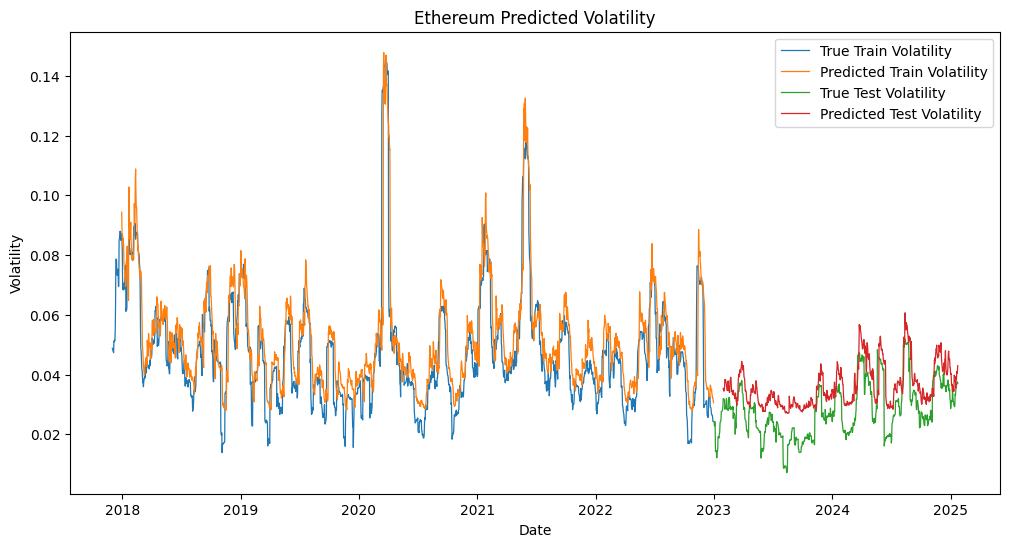

In [50]:
def predict_and_plot_ethereum(pipeline, train_data, test_data):
    y_pred_train = pipeline.predict(train_data[features].values)[:, 4]
    y_pred_test = pipeline.predict(test_data[features].values)[:, 4]
    
    plt.figure(figsize=(12, 6))
    plt.plot(train_data["Date"], train_data["Volatility"], label="True Train Volatility", linewidth=0.9)
    plt.plot(train_data["Date"][-len(y_pred_train):], y_pred_train, label="Predicted Train Volatility", linewidth=0.9)
    plt.plot(test_data["Date"], test_data["Volatility"], label="True Test Volatility", linewidth=0.9)
    plt.plot(test_data["Date"][-len(y_pred_test):], y_pred_test, label="Predicted Test Volatility", linewidth=0.9)

    plt.title("Ethereum Predicted Volatility")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.show()

predict_and_plot_ethereum(ethereum_pipeline, ethereum_train_data, ethereum_test_data)
